In [1]:
from gidnet.qubitreuse import GidNET

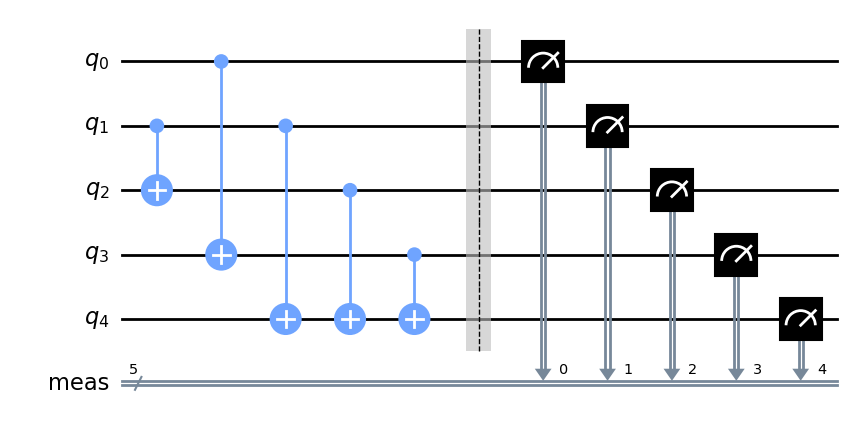

In [2]:
from qiskit import QuantumCircuit
circ = QuantumCircuit(5)

circ.cx(1,2)
circ.cx(0,3)

circ.cx(1,4)
circ.cx(2,4)
circ.cx(3,4)


circ.measure_all()

circ.draw('mpl')

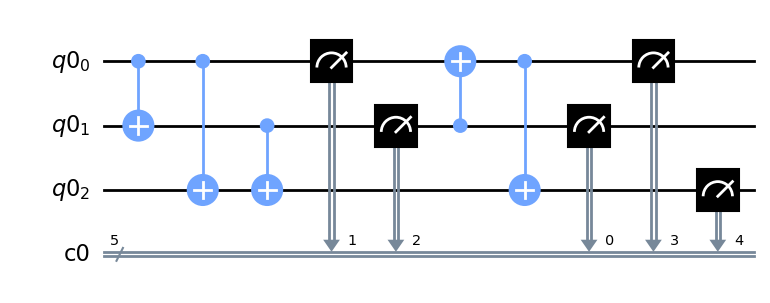

In [3]:
gidnet = GidNET(circ)
gidnet.compile_to_dynamic_circuit(draw=True)

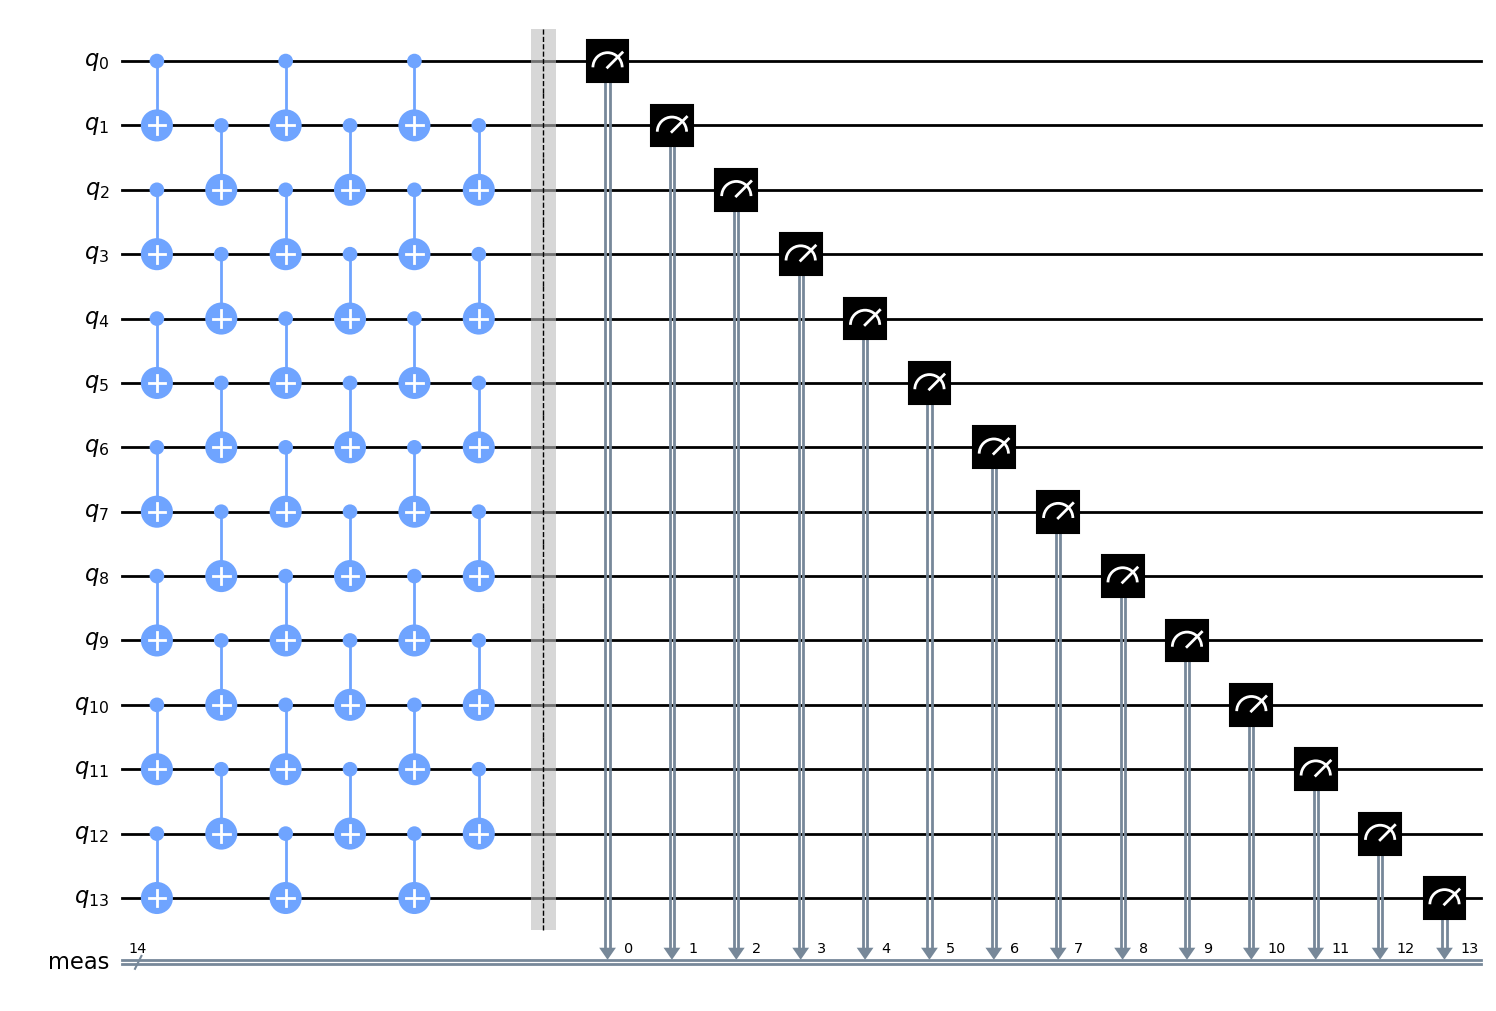

In [4]:
num_qubits = 14
k = 3
brick_circ = QuantumCircuit(num_qubits)

for i in range(k):
    for q in range(int(num_qubits/2)):
        brick_circ.cx(2*q, 2*q+1)
        
    for q in range(int(num_qubits/2)-1):
        brick_circ.cx(2*q+1, 2*q+2)
        
    # circ.barrier()

brick_circ.measure_all()

brick_circ.draw('mpl', fold=1)


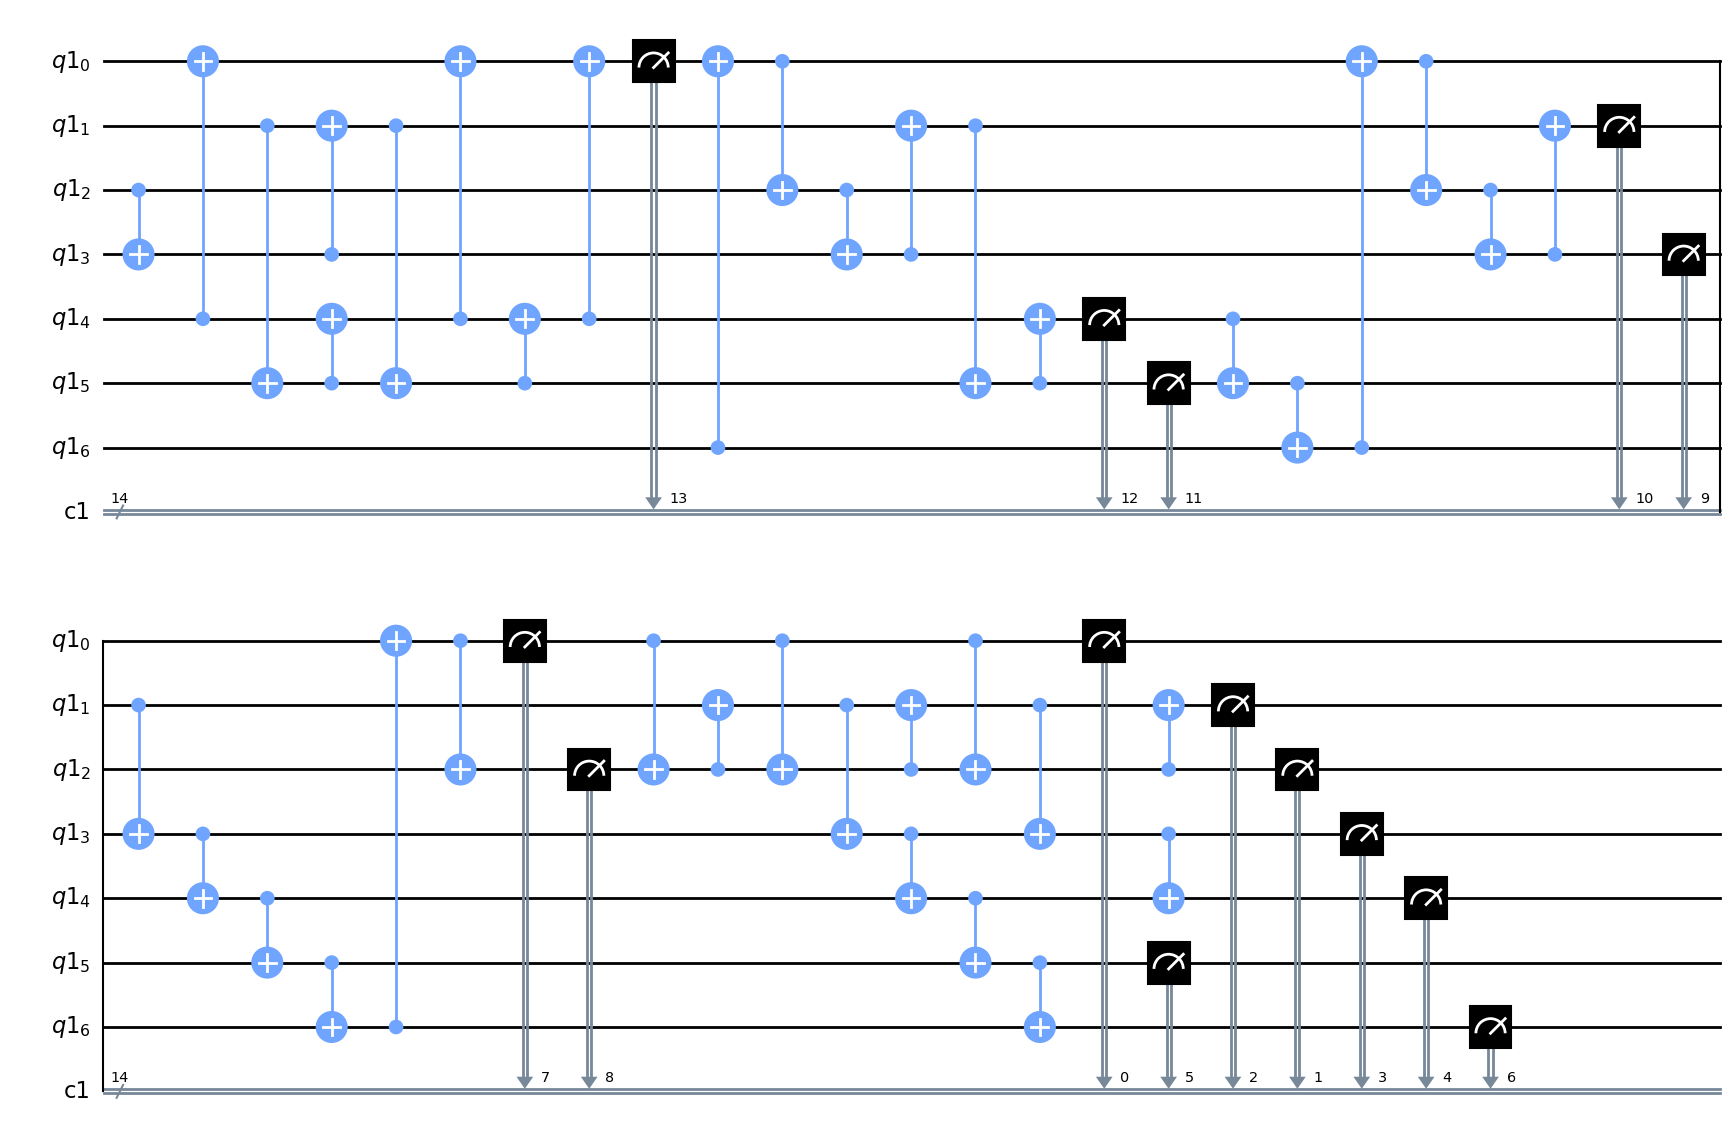

In [5]:
gidnet = GidNET(brick_circ)
gidnet.compile_to_dynamic_circuit(iterations=20, draw=True)

In [6]:
gidnet.dynamic_circuit_width

7

In [ ]:
circuit_sizes = ["4x4", "4x5", "5x5", "5x6", "6x6", "6x7", "7x7", "7x8", "8x8", "8x9",
                "9x9", "9x10", "10x10", "10x11", "11x11", "11x12", "12x12"]

directory_path = "../data"
cycle_num = 10  # depth =12
iterations = 10


gidnet_average_time = []
gidnet_std_time = []
gidnet_qubit_width = []

for i, num_qubits in enumerate(circuit_sizes):
    print("circuit", i+1, "running")
    qiskit_circuit, qnet_circuit = create_qiskit_and_qnet_GRCS_circuits(num_qubits, cycle_num, directory_path)


    #### GIDNET EXPERIMENT BEGINS #####
    print("GidNET")
    gidnet = GidNET(qiskit_circuit)
    gidnet_time = %timeit -o gidnet.compile_to_dynamic_circuit(iterations)

    gidnet_average_time.append(gidnet_time.average)
    gidnet_std_time.append(gidnet_time.stdev)
    gidnet_qubit_width.append(gidnet.dynamic_circuit_width)

    #### QNET EXPERIMENT BEGINS #####
    print("QNET")
    # convert Qiskit circuit to QNET circuit type
    qnet_time = %timeit -o compute_qnet_qubit_reuse_list_timing(qnet_circuit, method="random", shots=iterations)
    qnet_result = compute_qnet_qubit_reuse_list(qnet_circuit, method="random", shots=iterations)

    qnet_average_time.append(qnet_time.average)
    qnet_std_time.append(qnet_time.stdev)
    qnet_qubit_width.append(len(qnet_result))


    #### Qiskit EXPERIMENT BEGINS #####
    print("Qiskit")
    qiskit_time = %timeit -o apply_qiskit_qubit_reuse(qiskit_circuit)
    compiled_qiskit_circuit = apply_qiskit_qubit_reuse(qiskit_circuit)

    qiskit_average_time.append(qiskit_time.average)
    qiskit_std_time.append(qiskit_time.stdev)
    qiskit_qubit_width.append(compiled_qiskit_circuit.num_qubits)

    print()


# Create DataFrames of results
df12_gidnet = pd.DataFrame(
    {
    'Circuit Sizes': [safe_eval(s) for s in circuit_sizes],
    'GidNET Average Runtime': gidnet_average_time,  # Added comma
    'GidNET Stdev Runtime': gidnet_std_time,  # Added comma
    'GidNET Width': gidnet_qubit_width,
    }
                        )


df12_qnet = pd.DataFrame( 
    {
    'Circuit Sizes': [safe_eval(s) for s in circuit_sizes],
    'QNET-random Average Runtime': qnet_average_time,  # Added comma
    'QNET-random Stdev Runtime': qnet_std_time,  # Added comma
    'QNET-random Width': qnet_qubit_width
    }
                        )

df12_qiskit = pd.DataFrame( 
    {
    'Circuit Sizes': [safe_eval(s) for s in circuit_sizes],
    'Qiskit Average Runtime': qiskit_average_time,  # Added comma
    'Qiskit Stdev Runtime': qiskit_std_time,  # Added comma
    'Qiskit Width': qiskit_qubit_width,
    }
                        )


# Merging the DataFrames on 'Circuit Sizes'
df12 = pd.merge(df12_gidnet, df12_qnet, on='Circuit Sizes', how='outer', suffixes=('_gidnet', '_qnet'))
df12 = pd.merge(df12, df12_qiskit, on='Circuit Sizes', how='outer', suffixes=('', '_qiskit'))


In [7]:
# Generating data for Supremacy circuit of depth=11 
from benchmarks.biadu_qnet_qubit_reuse.baidu_qnet_qr import (compute_qnet_qubit_reuse_list, 
                                                  from_qiskit_to_qnet,
                                                 compute_qnet_qubit_reuse_list_timing)
from gidnet.qubitreuse import GidNET
from gidnet.utils import apply_qiskit_qubit_reuse
from benchmarks.qcg.helper_functions.benchmarks import generate_circ
from qiskit import QuantumCircuit
import numpy as np
import pandas as pd


circuit_sizes = [16, 20, 25, 30, 36, 42, 49, 56, 64, 72, 81, 90, 100, 110, 121, 132, 144]
circuit_sizes = [16, 20]
iterations = 10 # shots for qnet algorithm

# GidNET params
gidnet_average_time = []
gidnet_std_time = []
gidnet_qubit_width = []

# QNET params
qnet_average_time = []
qnet_std_time = []
qnet_qubit_width = []


# Qiskit Params
qiskit_average_time = []
qiskit_std_time = []
qiskit_qubit_width = []

for i, circuit_size in enumerate(circuit_sizes):
    print("circuit", i+1, "running")
    circuit_type = "supremacy"

    supremacy_circuit = generate_circ(
            num_qubits=circuit_size,
            depth=1,
            circuit_type=circuit_type,
            reg_name="q",
            connected_only=True,
            seed=None,
    )

    if supremacy_circuit is not None:
        supremacy_circuit.measure_all()

    gidnet = GidNET(supremacy_circuit)

    #### GIDNET EXPERIMENT BEGINS #####
    print("GidNET")
    gidnet_time = %timeit -o gidnet.compile_to_dynamic_circuit(iterations)

    gidnet_average_time.append(gidnet_time.average)
    gidnet_std_time.append(gidnet_time.stdev)
    gidnet_qubit_width.append(gidnet.dynamic_circuit_width)

    #### QNET EXPERIMENT BEGINS #####
    print("QNET")
    # convert Qiskit circuit to QNET circuit type
    qnet_supremacy_circuit = from_qiskit_to_qnet(supremacy_circuit)

    qnet_time = %timeit -o compute_qnet_qubit_reuse_list_timing(qnet_supremacy_circuit, method="random", shots=iterations)
    qnet_result = compute_qnet_qubit_reuse_list(qnet_supremacy_circuit, method="random", shots=iterations)

    qnet_average_time.append(qnet_time.average)
    qnet_std_time.append(qnet_time.stdev)
    qnet_qubit_width.append(len(qnet_result))


    #### Qiskit EXPERIMENT BEGINS #####
    print("Qiskit")
    qiskit_time = %timeit -o apply_qiskit_qubit_reuse(supremacy_circuit)
    compiled_qiskit_circuit = apply_qiskit_qubit_reuse(supremacy_circuit)

    qiskit_average_time.append(qiskit_time.average)
    qiskit_std_time.append(qiskit_time.stdev)
    qiskit_qubit_width.append(compiled_qiskit_circuit.num_qubits)

    print()



# Create DataFrames of results
df11_gidnet = pd.DataFrame(
    {
    'Circuit Sizes': circuit_sizes,
    'GidNET Average Runtime': gidnet_average_time,  # Added comma
    'GidNET Stdev Runtime': gidnet_std_time,  # Added comma
    'GidNET Width': gidnet_qubit_width,
    }
                        )


df11_qnet = pd.DataFrame( 
    {
    'Circuit Sizes': circuit_sizes,
    'QNET-random Average Runtime': qnet_average_time,  # Added comma
    'QNET-random Stdev Runtime': qnet_std_time,  # Added comma
    'QNET-random Width': qnet_qubit_width
    }
                        )

df11_qiskit = pd.DataFrame( 
    {
    'Circuit Sizes': circuit_sizes,
    'Qiskit Average Runtime': qiskit_average_time,  # Added comma
    'Qiskit Stdev Runtime': qiskit_std_time,  # Added comma
    'Qiskit Width': qiskit_qubit_width,
    }
                        )


# Merging the DataFrames on 'Circuit Sizes'
df11 = pd.merge(df11_gidnet, df11_qnet, on='Circuit Sizes', how='outer', suffixes=('_gidnet', '_qnet'))
df11 = pd.merge(df11, df11_qiskit, on='Circuit Sizes', how='outer', suffixes=('', '_qiskit'))

# Save the combined DataFrame to CSV
# df11.to_csv('data_supremacy_cct/width_and_runtime_supremacy_cct_depth_11.csv', index=False)

circuit 1 running
Generating 4x4, 1+8+1 supremacy circuit
GidNET
43.3 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
QNET
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
267 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Qiskit
38.8 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

circuit 2 running
Generating 5x4, 1+8+1 supremacy circuit
GidNET
58.5 ms ± 5.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
QNET
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
696 ms ± 44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Qiskit
61 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



OSError: Cannot save file into a non-existent directory: 'data_supremacy_cct'

In [ ]:
stop

In [ ]:
# Combination of df11, df12 and df15 data

# first plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the data for each depth
df11 = pd.read_csv('combined_data/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv')
df12 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_10_data.csv')
df15 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_13_data.csv')

# Adjust the figure size and set DPI for higher quality output
plt.figure(figsize=(8, 6), dpi=400)

# Define distinct linestyles
styles = ['-', ':', '-.']
depth_labels = ['Depth 11', 'Depth 12', 'Depth 15']

# Define colors and markers
colors = {'GidNET': 'green', 'QNET': 'blue', 'Qiskit': 'red'}
markers = {'GidNET': 'o', 'QNET': '^', 'Qiskit': 'x'}
algorithm_labels = list(colors.keys())

# Plot for each depth (GidNET, QNET, Qiskit)
for i, df in enumerate([df11, df12, df15]):
    plt.plot(df["Circuit Sizes"], df["GidNET Width"], marker=markers['GidNET'], color=colors['GidNET'], linestyle=styles[i], markersize=4)
    plt.plot(df["Circuit Sizes"], df["QNET Width"], marker=markers['QNET'], color=colors['QNET'], linestyle=styles[i], markersize=4)
    plt.plot(df["Circuit Sizes"], df["Qiskit Width"], marker=markers['Qiskit'], color=colors['Qiskit'], linestyle=styles[i], markersize=4)

# Adding titles and labels
plt.xlabel('Initial Circuit Width', fontsize=14, fontweight='bold')
plt.ylabel('Final Circuit Width', fontsize=14, fontweight='bold')

# Create custom legends
from matplotlib.lines import Line2D

# Legend for algorithms with just markers
algorithm_handles = [Line2D([0], [0], color=colors[key], marker=markers[key], linestyle='None', markersize=8) for key in colors]

# Legend for depths
depth_handles = [Line2D([0], [0], color='black', lw=4, linestyle=style) for style in styles]

# Introduce spacer to align legends side by side properly
spacer = Line2D([0], [0], color='none', marker='None', linestyle='None')

# Combine handles and labels with spacer
combined_handles = algorithm_handles + [spacer] + depth_handles
combined_labels = algorithm_labels + [""] + depth_labels

# Add single legend
plt.legend(prop={'size': 12, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=2, handlelength=3, fontsize=12, frameon=True, borderpad=1, labelspacing=1.2, columnspacing=4)

plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=14)

# Enable grid for better visibility
# plt.grid(True)

# Save the figure as a PDF file for high-quality vector graphics
plt.savefig('combined_plots/GidNET_v02_QNET_and_Qiskit_width_reduction.pdf', format='pdf', bbox_inches='tight')

# Display the plot
plt.show()


In [ ]:
# second paper plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

# Define model functions for polynomial fitting
def model_gidnet(n, c):
    # return c * np.log2(n) * n**3
    return c * n**3

def model_qnet(n, c):
    return c * n**5

# Load data for each depth
df11 = pd.read_csv('combined_data/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv')
df12 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_10_data.csv')
df15 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_13_data.csv')

# Figure settings
plt.figure(figsize=(10, 8), dpi=600)

# Define colors, markers, and styles
colors = {'GidNET': 'green', 'QNET': 'blue', 'Qiskit': 'red'}
markers = {'GidNET': 'o', 'QNET': '^', 'Qiskit': 'x'}
styles = ['-', ':', '-.']
depth_labels = ['Depth 11', 'Depth 12', 'Depth 15']
# fit_labels = [r'GidNET Fit: c⋅n3logn\mathbf{c \cdot n^3 \log{n}}', r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}']
fit_labels = [r'GidNET Fit: c⋅n3\mathbf{c \cdot n^3}', r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}']

# Plotting
dfs = [df11, df12, df15]
for i, df in enumerate(dfs):
    popt_gidnet, _ = curve_fit(model_gidnet, df["Circuit Sizes"], df["GidNET Average Runtime"])
    popt_qnet, _ = curve_fit(model_qnet, df["Circuit Sizes"], df["QNET Average Runtime"])

    plt.errorbar(df["Circuit Sizes"], df["GidNET Average Runtime"], yerr=df["GidNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['GidNET'], color=colors['GidNET'], capsize=5, label=f'GidNET {depths[i]}')
    if i==1:
        plt.plot(df["Circuit Sizes"], model_gidnet(df["Circuit Sizes"], *popt_gidnet), color='#cc79a7', linestyle="--",
             label=fit_labels[0])

    plt.errorbar(df["Circuit Sizes"], df["QNET Average Runtime"], yerr=df["QNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['QNET'], color=colors['QNET'], capsize=5, label=f'QNET {depths[i]}')
    if i==1:
        plt.plot(df["Circuit Sizes"], model_qnet(df["Circuit Sizes"], *popt_qnet), color="orange", linestyle="--",
             label=fit_labels[1])

    plt.errorbar(df["Circuit Sizes"], df["Qiskit Average Runtime"], yerr=df["Qiskit Stdev Runtime"],
                 fmt=styles[i], marker=markers['Qiskit'], color=colors['Qiskit'], capsize=5, label=f'Qiskit {depths[i]}')

# Labels and scale
plt.xlabel('Initial Circuit Width', fontsize=16, fontweight='bold')
plt.ylabel('Average Runtime (s)', fontsize=16, fontweight='bold')
plt.yscale('log')

plt.xticks(fontweight='bold', fontsize=16)
plt.yticks(fontweight='bold', fontsize=16)

# Legends
# algorithm_handles = [Line2D([0], [0], marker=markers[name], color=colors[name], linestyle='None', markersize=10) for name in colors]
# depth_handles = [Line2D([0], [0], color='black', linestyle=style, markersize=10) for style in styles]
# fit_handles = [Line2D([0], [0], color='black', linestyle='--', markersize=10) for _ in fit_labels]

# combined_handles = algorithm_handles + [Line2D([0], [0], marker='None', linestyle='None')] + depth_handles + fit_handles
# combined_labels = list(colors.keys()) + [''] + depths + fit_labels

# Create custom legends
from matplotlib.lines import Line2D

# Legend for algorithms with just markers
algorithm_handles = [Line2D([0], [0], color=colors[key], marker=markers[key], linestyle='None', markersize=8) for key in colors]

# Legend for depths
depth_handles = [Line2D([0], [0], color='black', lw=3, linestyle=style) for style in styles]

# Legend for fits
fit_handles = [Line2D([0], [0], color=color, lw=3, linestyle='--', markersize=10) for color in ['#cc79a7', "orange"]]

# Introduce spacer to align legends side by side properly
spacer = Line2D([0], [0], color='none', marker='None', linestyle='None')

# Combine handles and labels with spacer
combined_handles = algorithm_handles + [spacer] + depth_handles + [spacer] + fit_handles
combined_labels = algorithm_labels + [""] + depth_labels + [""] + fit_labels

# plt.legend(prop={'size': 12, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=4, frameon=True, fontsize=12, handlelength=2.5, handletextpad=0.5, columnspacing=3, borderpad=1)
plt.legend(prop={'size': 13, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=3, handlelength=3, fontsize=12, frameon=True, borderpad=1, labelspacing=1.2, columnspacing=1.1)

# Save and display
plt.savefig('combined_plots/GidNET_QNET_Qiskit_runtime_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()


### F-test and R-squared values

In [73]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Define your circuit sizes and corresponding theoretical and experimental values
circuit_size = np.array(df["Circuit Sizes"])
theoretical_values = np.array(model_gidnet(df["Circuit Sizes"], *popt_gidnet))
experimental_values = np.array(df["GidNET Average Runtime"])

# Fit the polynomial regression
degree=3
poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(circuit_size.reshape(-1, 1))
model = LinearRegression().fit(X_poly, experimental_values)
predicted_values = model.predict(X_poly)

# Calculate R-squared value
r_squared = r2_score(experimental_values, predicted_values)

# Compute the F-statistic
n = len(circuit_size)
k = degree + 1  # Degree of polynomial + 1 (for the intercept)
f_statistic = (r_squared / (1 - r_squared)) * ((n - k - 1) / k)

print("R-squared value:", r_squared)
print("F-statistic:", f_statistic)


R-squared value: 0.9989575499955387
F-statistic: 2874.835855111489


In [ ]:
n=4
R-squared value: 0.9989617396275322
F-statistic: 2116.728987697878

In [78]:
# Define your circuit sizes and corresponding theoretical and experimental values
circuit_size = np.array(df["Circuit Sizes"])
theoretical_values = np.array(model_qnet(df["Circuit Sizes"], *popt_qnet))
experimental_values = np.array(df["QNET Average Runtime"])


# Fit the polynomial regression
degree=5
poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(circuit_size.reshape(-1, 1))
model = LinearRegression().fit(X_poly, experimental_values)
predicted_values = model.predict(X_poly)

# Calculate R-squared value
r_squared = r2_score(experimental_values, predicted_values)

# Compute the F-statistic
n = len(circuit_size)
k = degree + 1  # Degree of polynomial + 1 (for the intercept)
f_statistic = (r_squared / (1 - r_squared)) * ((n - k - 1) / k)

print("R-squared value:", r_squared)
print("F-statistic:", f_statistic)

R-squared value: 0.9995528400805823
F-statistic: 3725.5606502115834


### GidNET Speedup

#### Geometric mean speedup

In [8]:
import pandas as pd
import numpy as np

# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate the individual speedups
speedup_vs_qnet = data['QNET Average Runtime'] / data['GidNET Average Runtime']
# speedup_vs_qiskit = data['Qiskit Average Runtime'] / data['GidNET Average Runtime']
speedup_vs_qiskit = data['GidNET Average Runtime'] / data['Qiskit Average Runtime']

# Calculate the geometric mean of the speedups
geo_mean_speedup_vs_qnet = np.prod(speedup_vs_qnet) ** (1 / len(speedup_vs_qnet))
geo_mean_speedup_vs_qiskit = np.prod(speedup_vs_qiskit) ** (1 / len(speedup_vs_qiskit))

# Calculate the percentage execution time reduction
percent_reduction_vs_qnet = 100 * (1 - 1 / geo_mean_speedup_vs_qnet)
percent_reduction_vs_qiskit = 100 * (1 - 1 / geo_mean_speedup_vs_qiskit)

# Create a summary DataFrame
performance_improvement_geo_mean = pd.DataFrame({
    'Geometric Mean Speedup vs QNET (X)': [geo_mean_speedup_vs_qnet],
    'Percentage Execution Time Reduction vs QNET (%)': [percent_reduction_vs_qnet],
    'Geometric Mean Speedup vs Qiskit (X)': [geo_mean_speedup_vs_qiskit],
    'Percentage Execution Time Reduction vs Qiskit (%)': [percent_reduction_vs_qiskit]
})

performance_improvement_geo_mean


,Geometric Mean Speedup vs QNET (X),Percentage Execution Time Reduction vs QNET (%),Geometric Mean Speedup vs Qiskit (X),Percentage Execution Time Reduction vs Qiskit (%)
0,38.204693,97.382521,12.602489,92.065059


In [9]:
# speedup_vs_qnet

In [2]:
import pandas as pd
import numpy as np

# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate the individual speedups for width
speedup_width_vs_qnet = data['QNET Width'] / data['GidNET Width']
speedup_width_vs_qiskit = data['Qiskit Width'] / data['GidNET Width']

# Calculate the geometric mean of the speedups for width
geo_mean_speedup_width_vs_qnet = np.prod(speedup_width_vs_qnet) ** (1 / len(speedup_width_vs_qnet))
geo_mean_speedup_width_vs_qiskit = np.prod(speedup_width_vs_qiskit) ** (1 / len(speedup_width_vs_qiskit))

# Calculate the percentage width reduction
percent_width_reduction_vs_qnet = 100 * (1 - 1 / geo_mean_speedup_width_vs_qnet)
percent_width_reduction_vs_qiskit = 100 * (1 - 1 / geo_mean_speedup_width_vs_qiskit)

# Create a summary DataFrame
width_improvement_geo_mean = pd.DataFrame({
    'Geometric Mean Speedup Width vs QNET': [geo_mean_speedup_width_vs_qnet],
    'Geometric Mean Speedup Width vs Qiskit': [geo_mean_speedup_width_vs_qiskit],
    'Percentage Width Reduction vs QNET (%)': [percent_width_reduction_vs_qnet],
    'Percentage Width Reduction vs Qiskit (%)': [percent_width_reduction_vs_qiskit]
})

width_improvement_geo_mean


,Geometric Mean Speedup Width vs QNET,Geometric Mean Speedup Width vs Qiskit,Percentage Width Reduction vs QNET (%),Percentage Width Reduction vs Qiskit (%)
0,1.046496,2.45876,4.443043,59.329096


In [6]:
# speedup_width_vs_qnet

#### Arithmetic mean speedup

In [3]:
# Load the data
# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate the percentage reduction in average runtime
runtime_reduction_vs_qnet = (1 - data['GidNET Average Runtime'] / data['QNET Average Runtime']) * 100
runtime_reduction_vs_qiskit = (1 - data['Qiskit Average Runtime'] / data['GidNET Average Runtime']) * 100

# Calculate the percentage reduction in final circuit width
width_reduction_vs_qnet = (1 - data['GidNET Width'] / data['QNET Width']) * 100
width_reduction_vs_qiskit = (1 - data['GidNET Width'] / data['Qiskit Width']) * 100

# Create a summary DataFrame
performance_improvement = pd.DataFrame({
    'Circuit Sizes': data['Circuit Sizes'],
    'Runtime Reduction vs QNET (%)': runtime_reduction_vs_qnet,
    'Runtime Reduction vs Qiskit (%)': runtime_reduction_vs_qiskit,
    'Width Reduction vs QNET (%)': width_reduction_vs_qnet,
    'Width Reduction vs Qiskit (%)': width_reduction_vs_qiskit
})

performance_improvement


,Circuit Sizes,Runtime Reduction vs QNET (%),Runtime Reduction vs Qiskit (%),Width Reduction vs QNET (%),Width Reduction vs Qiskit (%)
0,16,76.677379,36.429906,0.000000,27.272727
1,20,86.357158,46.422394,0.000000,35.714286
2,25,91.456009,61.042653,-11.111111,37.500000
3,30,94.103426,70.143782,8.333333,47.619048
4,36,95.140537,79.570770,-9.090909,45.454545
5,42,96.333467,86.018883,7.692308,55.555556
6,49,96.844499,88.567135,0.000000,57.575758
7,56,97.414095,90.556150,21.052632,62.500000
8,64,97.612548,93.731425,5.263158,60.000000
9,72,98.144413,94.686821,10.000000,64.705882


In [85]:
performance_improvement["Runtime Reduction vs QNET (%)"].mean()

95.44880414838622

In [86]:
performance_improvement["Runtime Reduction vs Qiskit (%)"].mean()

84.05367199899833

In [88]:
# Load the data
# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate how many X faster
runtime_reduction_vs_qnet = (data['QNET Average Runtime'] / data['GidNET Average Runtime'])
runtime_reduction_vs_qiskit = (data['GidNET Average Runtime'] / data['Qiskit Average Runtime'])

# Calculate the percentage reduction in final circuit width
width_reduction_vs_qnet = (1 - data['GidNET Width'] / data['QNET Width']) * 100
width_reduction_vs_qiskit = (1 - data['GidNET Width'] / data['Qiskit Width']) * 100

# Create a summary DataFrame with corrected values
performance_improvement_corrected = pd.DataFrame({
    'Circuit Sizes': data['Circuit Sizes'],
    'Runtime Reduction vs QNET (x)': runtime_reduction_vs_qnet,
    'Runtime Reduction vs Qiskit (x)': runtime_reduction_vs_qiskit,
    'Width Reduction vs QNET (%)': width_reduction_vs_qnet,
    'Width Reduction vs Qiskit (%)': width_reduction_vs_qiskit
})

performance_improvement_corrected


,Circuit Sizes,Runtime Reduction vs QNET (x),Runtime Reduction vs Qiskit (x),Width Reduction vs QNET (%),Width Reduction vs Qiskit (%)
0,16,4.287683,1.573067,0.000000,27.272727
1,20,7.329851,1.866451,0.000000,35.714286
2,25,11.704132,2.566910,-11.111111,37.500000
3,30,16.959001,3.349386,8.333333,47.619048
4,36,20.578407,4.894947,-9.090909,45.454545
5,42,27.273720,7.152504,7.692308,55.555556
6,49,31.690692,8.746714,0.000000,57.575758
7,56,38.671184,10.588902,21.052632,62.500000
8,64,41.885651,15.952589,5.263158,60.000000
9,72,53.891291,18.821125,10.000000,64.705882


In [89]:
performance_improvement_corrected["Runtime Reduction vs QNET (x)"].mean()

56.30532267249479

In [90]:
performance_improvement_corrected["Runtime Reduction vs Qiskit (x)"].mean()

22.723991611628815

In [91]:
performance_improvement_corrected["Width Reduction vs QNET (%)"].mean()

4.084746366456905

In [92]:
performance_improvement_corrected["Width Reduction vs Qiskit (%)"].mean()

57.43161547243526

In [93]:
# Calculate the average improvement of GidNET over QNET and Qiskit in terms of runtime
gidnet_faster_than_qnet = (data['QNET Average Runtime'] - data['GidNET Average Runtime']) / data['QNET Average Runtime']
# gidnet_faster_than_qiskit = (data['Qiskit Average Runtime'] - data['GidNET Average Runtime']) / data['Qiskit Average Runtime']
# Calculate how much faster Qiskit is compared to GidNET in percentage terms
qiskit_faster_than_gidnet = (data['GidNET Average Runtime'] - data['Qiskit Average Runtime']) / data['GidNET Average Runtime']



average_improvement_qnet = gidnet_faster_than_qnet.mean() * 100
# average_improvement_qiskit = gidnet_faster_than_qiskit.mean() * 100
average_faster_qiskit = qiskit_faster_than_gidnet.mean() * 100

average_improvement_qnet, average_faster_qiskit


(95.44880414838622, 84.05367199899834)

In [94]:
# Re-load the data from the newly provided file path and calculate the circuit width differences
# file_path_new = '/mnt/data/combined_width_and_runtime_cutqc_supremacy_data.csv'
# data_new = pd.read_csv(file_path_new)

# Calculate the percentage improvements in circuit width for GidNET compared to QNET and Qiskit
gidnet_better_than_qnet_width_new = ((data['QNET Width'] - data['GidNET Width']) / data['QNET Width']) 
gidnet_better_than_qiskit_width_new = ((data['Qiskit Width'] - data['GidNET Width']) / data['Qiskit Width']) 

average_better_width_qnet_new = gidnet_better_than_qnet_width_new.mean() * 100
average_better_width_qiskit_new = gidnet_better_than_qiskit_width_new.mean() * 100

average_better_width_qnet_new, average_better_width_qiskit_new


(4.084746366456904, 57.43161547243526)

In [73]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Define your circuit sizes and corresponding theoretical and experimental values
circuit_size = np.array(df["Circuit Sizes"])
theoretical_values = np.array(model_gidnet(df["Circuit Sizes"], *popt_gidnet))
experimental_values = np.array(df["GidNET Average Runtime"])

# Fit the polynomial regression
degree=3
poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(circuit_size.reshape(-1, 1))
model = LinearRegression().fit(X_poly, experimental_values)
predicted_values = model.predict(X_poly)

# Calculate R-squared value
r_squared = r2_score(experimental_values, predicted_values)

# Compute the F-statistic
n = len(circuit_size)
k = degree + 1  # Degree of polynomial + 1 (for the intercept)
f_statistic = (r_squared / (1 - r_squared)) * ((n - k - 1) / k)

print("R-squared value:", r_squared)
print("F-statistic:", f_statistic)


R-squared value: 0.9989575499955387
F-statistic: 2874.835855111489
